# Load e imports

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings('ignore')

In [27]:
df = pd.read_csv('data_balanced.csv', encoding='utf-8')

In [28]:
df['result'].value_counts()

result
0    396313
1     33420
Name: count, dtype: int64

# Avaliando modelo por liga

## Preprocessamento

In [4]:
# Função para criar e aplicar o transformador de colunas
def create_preprocessor(X):
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
        ],
        remainder='passthrough'  # Mantém as características categóricas sem transformação
    )
    return preprocessor.fit(X)

## Treinamento

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score

# Lista das ligas únicas no conjunto de dados
leagues = df['league'].unique()

# Dicionário para armazenar histórico de treinamento e avaliação para cada liga
league_histories = {}
accuracy = []
# Loop por cada liga para criar, treinar e avaliar um modelo separado
t = len(leagues)
for league in leagues:
    print(f"Treinando modelo para a liga: {league} ({t} ligas restantes)")
    t -= 1
    
    # Filtrando o conjunto de dados para apenas a liga atual
    league_data = df[df['league'] == league]
    
    # Preparando os dados de entrada e saída
    X = league_data.drop(['result', 'league', 'homeTeam', 'awayTeam', 'match_id'], axis=1)
    y = league_data['result']

    preprocessor = create_preprocessor(X)
    X_transformed = preprocessor.transform(X)

    weight_calss_0 = (len(y) - y.sum()) / len(y)
    weight_calss_1 = y.sum() / len(y)

    class_weight = {0: weight_calss_0/2, 1: weight_calss_1*2}

    
    model_randomf = RandomForestClassifier(
                                            n_estimators=100, 
                                            # random_state=42, 
                                            min_samples_split=5, 
                                            min_samples_leaf=2, 
                                            # class_weight=class_weight
                                        )

    # Validação cruzada
    cv_scores = cross_val_score(model_randomf, X_transformed, y, cv=5, scoring='roc_auc')
    print(f"Média AUC para {league}: {cv_scores.mean()}")

    # acuracia
    cv_scores = cross_val_score(model_randomf, X_transformed, y, cv=5, scoring='accuracy')
    print(f"Média Acurácia para {league}: {cv_scores.mean()}")
    accuracy.append(cv_scores.mean())

    # Treinando e avaliando o modelo
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    model_randomf.fit(X_train, y_train)
    train_auc = roc_auc_score(y_train, model_randomf.predict_proba(X_train)[:, 1])
    test_auc = roc_auc_score(y_test, model_randomf.predict_proba(X_test)[:, 1])

    feature_importance = model_randomf.feature_importances_

    # Armazenando a avaliação em um dicionário
    league_histories[league] = {
        'cv_auc_mean': cv_scores.mean(),
        'train_auc': train_auc,
        'test_auc': test_auc,
        'feature_importance': feature_importance
    }

    # Predicting the values
    y_pred = model_randomf.predict(X_test)
    
    # classification report
    print(classification_report(y_test, y_pred))
    print()
print(f"Acurácia média Total: {np.mean(accuracy)}")

Treinando modelo para a liga: South America - Copa Libertadores (33 ligas restantes)
Média AUC para South America - Copa Libertadores: 0.4258897897960171
Média Acurácia para South America - Copa Libertadores: 0.448394776711637
              precision    recall  f1-score   support

           0       0.67      0.70      0.69        81
           1       0.71      0.67      0.69        86

    accuracy                           0.69       167
   macro avg       0.69      0.69      0.69       167
weighted avg       0.69      0.69      0.69       167


Treinando modelo para a liga: Asia - AFC Champions League (32 ligas restantes)
Média AUC para Asia - AFC Champions League: 0.41095949439816143
Média Acurácia para Asia - AFC Champions League: 0.4023928215353938
              precision    recall  f1-score   support

           0       0.79      0.64      0.71        59
           1       0.70      0.83      0.76        60

    accuracy                           0.74       119
   macro avg    

## Avaliando importancia das features de cada liga

In [6]:
dataframe_league = pd.DataFrame.from_dict(league_histories, orient='index')
dataframe_league

,cv_auc_mean,train_auc,test_auc,feature_importance
South America - Copa Libertadores,0.448395,0.998915,0.761771,"[0.1259537881073866, 0.0018410736546800885, 0...."
Asia - AFC Champions League,0.402393,0.999184,0.805932,"[0.12042837065394142, 0.0, 0.00174378570495641..."
Brazil - Paulista A1,0.459615,0.997111,0.805473,"[0.11676637880801645, 0.0007530731329537303, 0..."
South America - Copa Sudamericana,0.481804,0.998491,0.716940,"[0.11068285738497737, 0.00022408796146030594, ..."
Japan - J-League,0.438109,0.998666,0.784174,"[0.1242166055736789, 0.00019148568325168198, 0..."
USA - Major League Soccer,0.381100,0.998842,0.730331,"[0.13416152348932833, 0.0037481216592806376, 0..."
Mexico - Liga MX,0.418085,0.999420,0.757235,"[0.12293004383799368, 0.0, 0.00022477775744451..."
Scotland - Premiership,0.415637,0.998174,0.726895,"[0.12462711299311251, 0.00011122394458894197, ..."
Brazil - Serie A,0.417077,0.998556,0.802394,"[0.12216611703311435, 0.0016286865149152895, 0..."
France - Ligue 1,0.429888,0.998651,0.699931,"[0.12619108357232217, 0.0015122408966142184, 0..."


In [7]:
# Calculando a média da importância de cada característica em todas as ligas
mean_feature_importances = pd.DataFrame(dataframe_league['feature_importance'].tolist()).mean().tolist()

# Convertendo a lista de importâncias das características em um DataFrame para facilitar a análise
df_feature_importances = pd.DataFrame(dataframe_league['feature_importance'].tolist())

# Calculando a variância da importância de cada característica em todas as ligas
feature_variances = df_feature_importances.var()

# Criando um DataFrame resumo para conter os dados de variância e correlação
summary_df = pd.DataFrame({
    'Mean Importance': mean_feature_importances,
    'Variance': feature_variances,
})

# Exibindo o DataFrame resumo ordenado por variância para ver quais características têm mais variabilidade entre as ligas
summary_df.sort_values('Variance', ascending=False, inplace=True)
summary_df.reset_index(inplace=True)
summary_df.rename(columns={'index': 'Feature'}, inplace=True)

feature_names = df.drop(['result', 'league', 'homeTeam', 'awayTeam', 'match_id'], axis=1).columns
# feature_names = df.drop(['result', 'league'], axis=1).columns

# Mapeando os números para os nomes das características
summary_df['Feature Name'] = summary_df['Feature'].apply(lambda x: feature_names[x])

summary_df.sort_values('Mean Importance', ascending=False)


,Feature,Mean Importance,Variance,Feature Name
1,0,0.119858,7.815833e-05,minute
3,24,0.104179,5.812164e-05,possessiontime_home
2,23,0.103380,6.945234e-05,possessiontime_away
8,22,0.067003,3.310041e-05,tackles_away
10,21,0.064460,3.106122e-05,tackles_home
0,18,0.059097,8.942194e-05,fouls_away
5,17,0.056868,4.534241e-05,fouls_home
12,3,0.047761,2.579713e-05,shotsHome
4,11,0.041011,4.821157e-05,shotsOffgoal_home
15,4,0.040955,2.069306e-05,shotsAway


- Importância das Características: A tabela fornece um valor de importância média para cada característica, que indica quanto essa característica contribui para a capacidade do modelo de fazer previsões. Quanto maior o valor, mais importante é a característica.

- Variância da Importância: A variância pode nos dizer quão consistente é a importância de uma característica entre os diferentes modelos de liga. Uma variância baixa significa que a característica tem aproximadamente a mesma importância em todas as ligas, enquanto uma variância alta sugere que a importância da característica varia significativamente entre as diferentes ligas.

- Diferenças entre as Ligas: Se algumas características têm uma alta variância na importância, isso pode indicar que as ligas têm dinâmicas diferentes que afetam os resultados dos jogos. Por exemplo, uma característica pode ser muito importante em uma liga, mas menos importante em outra.

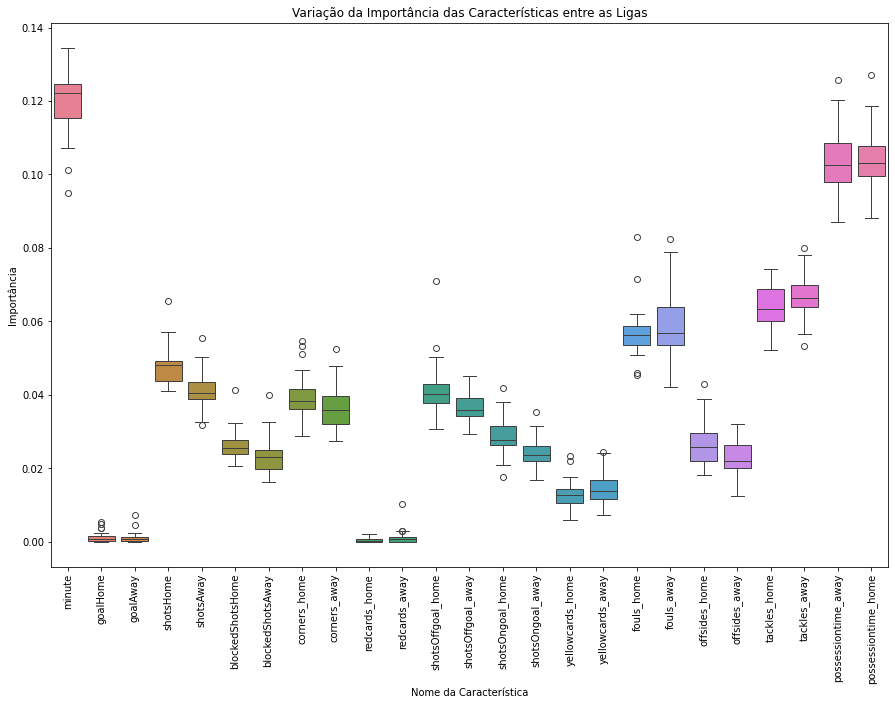

In [8]:
# Conversão do que ta no dataframe para lista
def convert_to_list(ndarray):
    # Verifica se o ndarray não é vazio e converte para lista
    return ndarray.tolist() if ndarray.size else []

importance_lists = dataframe_league['feature_importance'].apply(convert_to_list)

# Criando um DataFrame para armazenar os valores de importância para todas as ligas
feature_importance_df = pd.DataFrame(importance_lists.tolist())

# Calculando estatísticas descritivas para cada característica em todas as ligas
feature_importance_stats = feature_importance_df.describe()

# feature_names = summary_df['Feature Name'].tolist()

# Criar o gráfico de boxplot
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(data=feature_importance_df)
ax.set_title('Variação da Importância das Características entre as Ligas')
ax.set_xlabel('Nome da Característica')
ax.set_ylabel('Importância')
plt.xticks(ticks=np.arange(len(feature_names)), labels=feature_names, rotation=90)
plt.show()


- Variação na Importância: Características com boxplots mais largos indicam uma maior variação na sua importância entre as ligas. Isso sugere que o impacto dessas características é mais específico para cada liga. Por outro lado, características com boxplots mais estreitos mostram uma consistência maior, indicando que a importância dessas características é mais uniforme entre as ligas.
Outliers:

- Alguns boxplots têm pontos outliers, que representam ligas onde a importância da característica é notavelmente diferente do padrão observado na maioria das outras ligas. Esses outliers podem indicar casos específicos onde uma característica é particularmente mais ou menos relevante.

- Modelos Personalizados para Ligas: As características com maior variação (boxplots mais largos e/ou com outliers) são fortes candidatas a justificar a criação de modelos separados para cada liga. Isso permitiria que os modelos levassem em conta as peculiaridades de cada liga, resultando em previsões mais precisas.

- Características com menor variação podem ser tratadas de forma mais consistente entre os modelos para diferentes ligas.

# Engenharia de recursos

### Predicting Sports Results with Artificial Intelligence – A Proposal for Soccer Games
- Variáveis incluem gols, chutes, escanteios, força de ataque, desempenho de jogadores e técnicos, resultados históricos de jogos, e fatores como vantagem de jogar em casa, e o índice pi-rating, que considera o desempenho recente das equipes.
### Decentralized policy learning with partial observation and mechanical constraints for multiperson modeling - Keisuke Fujii
- As variáveis incluíram dados de localização dos jogadores (posição, velocidade, aceleração), resultados de jogos anteriores (como taxas de vitória e histórico de desempenho) e atributos individuais dos jogadores (como pontuação, assistências e rebotes).
### Stochastic Analysis of the Elo Rating Algorithm in Round-Robin Tournaments -  Daniel Gomes de Pinho Zanco, Leszek Szczecinski, Eduardo Vinicius Kuhn e Rui Seara
- Número de equipes, número total de jogos, indice de partida, habilidades das equipes, habilidades teóricas "verdadeiras", habilidades estimadas, vetor de programação, diferença entre as habilidades dos oponentes, resultado do jogo, parâmetro de tamanho de passo, vantagem de campo, variância de θ*, função logística, função densidade de probabilidade da distribuição logística, função de perda, matriz de autocorrelação de xk, desvio médio-quadrático das habilidades, comportamento médio da função de perda, limite inferior na média da função de perda, excesso médio de perda, constante de convergência no sentido médio, constante de convergência no sentido médio-quadrático, constante de tempo de convergência no sentido médio, constante de tempo de convergência no sentido médio-quadrático, limite que separa pequeno e grande v, valor ótimo do tamanho do passo para k jogos/partidas.
### Metodologia para Análise Preditiva de Resultados de Jogos Esportivos: Um Estudo de Caso por Jogos na NBA - Lourival Gonçalves Prata Netto
- Variáveis relacionadas às estatísticas de desempenho das equipes e jogadores, como eficiência ofensiva e defensiva, Net Rating (saldo de pontos de um time a cada 100 posses de bola), Pace (número médio de posses de bola por partida),  Além disso, são consideradas estatísticas individuais dos jogadores, refletindo o impacto deles nas eficiências ofensiva e defensiva da equipe. A pesquisa correlaciona meticulosamente essas variáveis com os resultados dos jogos para estabelecer modelos preditivos.
### Análise Preditiva em Partidas de Tênis - Suzana Barboza Carvalho
- Em “Ultimate Tennis Statistics” inclui estatísticas atualizadas dos jogadores e a “Tennis Abstract” oferecia uma base de dados consolidada sobre torneios e jogadores. O estudo analisou 169 atributos por jogador, categorizados em 18 grupos diferentes para gerenciar a complexidade e evitar o overfitting. Entre os atributos de performance analisados estão detalhes como nome do torneio, tipo de piso da quadra, nível do torneio, data, nomes dos jogadores, mão de domínio, idade, ranking, pontos de ranking, tie breaks decisivos, aces, duplas faltas, eficácia dos saques, pontos ganhos por game de serviço e retorno, break points enfrentados e ganhos, além de outras medidas de desempenho como tempo de ponto, games e sets por partida​​.
### Análise preditiva de fatores que influenciam na entrada na zona de finalização em partidas de futebol - Leandro Stival 
- Utilizados dados de 10 jogos completos, incluindo a posição de todos os jogadores a cada 30 frames por segundo. Eventos como faltas, gols e saídas pelas laterais também foram rotulados nos dados​​.
### Análise de desempenho esportivo baseada em dados estatísticos - Frederico Queiroz Nascimento 
- Variáveis incluem detalhes das partidas, como vencedor, localização (mandante ou visitante), finalizações, contra-ataques, ligação direta, posse de bola, cruzamentos, passes, percentual de vitórias por mando de campo, análise do desempenho de times específicos em campeonatos distintos, e avaliações de desempenho baseadas em combinações específicas de variáveis, como a correlação entre finalizações e posicionamento ou entre contra-ataques e ligação direta, enriquecendo a análise estratégica para os clubes de futebol.
### Análise do Jogo de Futebol: Padrões de Jogo Ofensivo em Equipas de Alto Rendimento - Uma Abordagem Qualitativa
- Padrões sequenciais de conduta, relações excitatórias entre condutas, e conceitos e filosofias de jogo extraídos das entrevistas
### Previsão de resultado de jogos da NBA com algoritmos de machine learning
- Variáveis relacionadas a pontuação, jogadas, e rastreamento dos jogadores e da bola. Inclui métricas como arremessos de quadra, rebotes, faltas, e lances livres.
### The Validity and Reliability of Live Football Match Statistics From Champdas Master Match Analysis System
- Desempenho relacionado ao ataque, passe e defesa/goleiro. Estas incluem: mudança de ataque, entrar no terço ofensivo, chute, chute a gol, posse ganha, duelo aéreo, passe bem-sucedido, passe para frente, passe em profundidade, passe lateral, passe diagonal, passe para trás, passe longo, passe curto, assistência, passe consecutivo, passe chave, cruzamento, desarme, interceptação, rebatida, passe bloqueado, chute bloqueado, defesa, soco, defesa desviada e goleiro saída. Estas variáveis abrangem aspectos relacionados ao ataque, passe e defesa/goleiro, oferecendo uma análise detalhada das ações durante as partidas.

In [9]:
df.columns

Index(['minute', 'homeTeam', 'awayTeam', 'goalHome', 'goalAway', 'shotsHome',
       'shotsAway', 'blockedShotsHome', 'blockedShotsAway', 'league',
       'corners_home', 'corners_away', 'redcards_home', 'redcards_away',
       'shotsOffgoal_home', 'shotsOffgoal_away', 'shotsOngoal_home',
       'shotsOngoal_away', 'yellowcards_home', 'yellowcards_away',
       'fouls_home', 'fouls_away', 'offsides_home', 'offsides_away',
       'tackles_home', 'tackles_away', 'result', 'match_id',
       'possessiontime_away', 'possessiontime_home'],
      dtype='object')

# Adicionando novos atributos

In [29]:
# # df = pd.read_csv('data_trated.csv', encoding='utf-8')

# renomeando colunas para um padrao _home e _away
colunas = ['goal', 'shots', 'blockedShots' ]
for coluna in colunas:
    df.rename(columns={coluna+'Home': coluna+'_home'}, inplace=True)
    df.rename(columns={coluna+'Away': coluna+'_away'}, inplace=True)

In [30]:


# # função de calculo de força de ataque e defesa
# # maher foi o criador da formula que utiliza os gols marcados e sofridos para calcular a força de ataque e defesa
# # ele utiliza a media de gols marcados e sofridos para calcular a força de ataque e defesa
# # como o dataset são de jogos ao vivo, a abordagem utilizada foi o calculo de medias rolantes dos ultimos 10 jogos de cada time 
# def calculate_maher_stats(df, home_team_col, away_team_col, home_goals_col, away_goals_col):
#     df_cleaned = df.groupby('match_id').agg({
#     'homeTeam': 'first',
#     'awayTeam': 'first',
#     'goal_home': 'max',
#     'goal_away': 'max',
# }).reset_index()
    
#     # Ordenando os dados por match_id
#     df_sorted = df_cleaned.sort_values(by='match_id')

#     # Agrupando por time e match_id e calculando os gols acumulados
#     df_grouped_home = df_sorted.groupby([home_team_col, 'match_id'])[home_goals_col].sum().reset_index()
#     df_grouped_away = df_sorted.groupby([away_team_col, 'match_id'])[away_goals_col].sum().reset_index()

#     # Calculando as médias rolantes para a força de ataque em casa (a)
#     df_grouped_home['f_attack_home'] = df_grouped_home.groupby(home_team_col)[home_goals_col].transform(
#         lambda x: x.rolling(window=10, min_periods=1).mean()
#     )

#     # Calculando as médias rolantes para a força defensiva fora de casa (J)
#     df_grouped_away['f_defensive_away'] = df_grouped_away.groupby(away_team_col)[away_goals_col].transform(
#         lambda x: x.rolling(window=10, min_periods=1).mean()
#     )

#     # Unindo as estatísticas de volta ao DataFrame original
#     df_with_stats = df.merge(df_grouped_home[[home_team_col, 'match_id', 'f_attack_home']], on=[home_team_col, 'match_id'], how='left')
#     df_with_stats = df_with_stats.merge(df_grouped_away[[away_team_col, 'match_id', 'f_defensive_away']], left_on=[away_team_col, 'match_id'], right_on=[away_team_col, 'match_id'], how='left')

#     # agrupando por time e match_id e calculando os gols acumulados
#     df_grouped_home = df_sorted.groupby([home_team_col, 'match_id'])[away_goals_col].sum().reset_index()
#     df_grouped_away = df_sorted.groupby([away_team_col, 'match_id'])[home_goals_col].sum().reset_index()

#     # Para 'y' e 'S', cruzamos os dados dos gols dos times adversários
#     # Força Defensiva em Casa (y)
#     df_grouped_home['f_defensive_home'] = df_grouped_home.groupby(home_team_col)[away_goals_col].transform(
#         lambda x: x.rolling(window=10, min_periods=1).mean()
#     )
#     # Força de Ataque Fora de Casa (S)v
#     df_grouped_away['f_attack_away'] = df_grouped_away.groupby(away_team_col)[home_goals_col].transform(
#         lambda x: x.rolling(window=10, min_periods=1).mean()
#     )

#     # Unindo as estatísticas de volta ao DataFrame original
#     df_with_stats = df_with_stats.merge(df_grouped_home[[home_team_col, 'match_id', 'f_defensive_home']], on=[home_team_col, 'match_id'], how='left')
#     df_with_stats = df_with_stats.merge(df_grouped_away[[away_team_col, 'match_id', 'f_attack_away']], left_on=[away_team_col, 'match_id'], right_on=[away_team_col, 'match_id'], how='left')
    
#     return df_with_stats

# df = calculate_maher_stats(df, 'homeTeam', 'awayTeam', 'goal_home', 'goal_away')
# df.columns

In [31]:
# df = df_optimized.copy()

# # Drop duplicates to keep the final results of each match
# unique_matches = df.drop_duplicates(subset=['match_id'], keep='last')

# # Function to calculate rolling rates directly on the full dataset
# def calculate_rolling_rates_full(team_column, df, win_condition, loss_condition):
#     df[f'{team_column}_win'] = (df['result'] == win_condition).astype(int)
#     df[f'{team_column}_loss'] = (df['result'] == loss_condition).astype(int)
#     df[f'{team_column}_draw'] = (df['result'] == 0).astype(int)

#     # Calculate rolling averages for win, loss, and draw rates
#     df[f'win_rate_{team_column}'] = df.groupby(team_column)[f'{team_column}_win'].transform(lambda x: x.rolling(10, min_periods=1).mean())
#     df[f'loss_rate_{team_column}'] = df.groupby(team_column)[f'{team_column}_loss'].transform(lambda x: x.rolling(10, min_periods=1).mean())
#     df[f'draw_rate_{team_column}'] = df.groupby(team_column)[f'{team_column}_draw'].transform(lambda x: x.rolling(10, min_periods=1).mean())

#     return df

# # Calculate rolling rates for home and away teams on the full dataset
# df_full = calculate_rolling_rates_full('homeTeam', df, win_condition=1, loss_condition=-1)
# df_full = calculate_rolling_rates_full('awayTeam', df, win_condition=-1, loss_condition=1)

# # Check the shape of the dataframe to ensure the number of rows is retained
# df_full.shape



In [32]:
df.columns

Index(['minute', 'homeTeam', 'awayTeam', 'goal_home', 'goal_away',
       'shots_home', 'shots_away', 'blockedShots_home', 'blockedShots_away',
       'league', 'corners_home', 'corners_away', 'redcards_home',
       'redcards_away', 'shotsOffgoal_home', 'shotsOffgoal_away',
       'shotsOngoal_home', 'shotsOngoal_away', 'yellowcards_home',
       'yellowcards_away', 'fouls_home', 'fouls_away', 'offsides_home',
       'offsides_away', 'tackles_home', 'tackles_away', 'result', 'match_id',
       'match_result', 'win_rate_home', 'draw_rate_home', 'loss_rate_home',
       'win_rate_away', 'draw_rate_away', 'loss_rate_away', 'f_attack_home',
       'f_attack_away', 'f_defensive_home', 'f_defensive_away', '05ht_home',
       '15ht_home', '25ht_home', '05ht_away', '15ht_away', '25ht_away',
       'possessiontime_away', 'possessiontime_home'],
      dtype='object')

In [33]:
final_data_with_all_info = df.copy()

Em 'A League-Wide Evaluation of Factors Influencing Match Activity Profile in Elite Australian Football', Esmaeili, Clifton e Aughey (2020) destacam a complexidade e a multifatorialidade do desempenho em jogos de futebol de elite. As medidas de desempenho utilizadas para o sistema de análise de partidas 'Champdas Master System' foram divididas em 
- Desempenho relacionado ao ataque
- Desempenho relacionado com passes
- Desempenho relacionado com Defesa

Nos dados, as estatisticas,
- de ataque são: shotsOngoal, shotsOffGoal, corners
- relacionada a passes: possessiontime
- relacionado a defesa: tackles, blockedShots

Anotações: Essas variáveis do artigo foram utilizadas para interpretar o impacto com os proprios dados do jogo. O trabalho presente avalia essas características como variáveis preditoras

In [34]:
def calculate_efficiency_attack(df):
    df['shotAccuracy_home'] = df['shotsOngoal_home'] / (df['shots_home'] + 0.01)
    df['shotAccuracy_away'] = df['shotsOngoal_away'] / (df['shots_away'] + 0.01)
calculate_efficiency_attack(final_data_with_all_info)

def calculate_defense_performance(df):
    df['attackPressureOverTime_home'] = (df['shots_home'] + df['corners_home']) / df['minute']
    df['attackPressureOverTime_away'] = (df['shots_away'] + df['corners_away']) / df['minute']

    df['aggrressionOverTime_home'] = (df['redcards_home'] + df['yellowcards_home'] + df['fouls_home']) / df['minute']
    df['aggresssionOverTime_away'] = (df['redcards_away'] + df['yellowcards_away'] + df['fouls_away']) / df['minute']

    df['defensiveEfficacy_home'] = df['blockedShots_home'] / (df['shotsOngoal_home'] + 0.01) # chutes que foram bloqueados e chutes que foram no gol da equipe adversaria
    df['defensiveEfficacy_away'] = df['blockedShots_away'] / (df['shotsOngoal_away'] + 0.01) 

    df['taklesOverTime_home'] = df['tackles_home'] / df['minute']
    df['taklesOverTime_away'] = df['tackles_away'] / df['minute']
calculate_defense_performance(final_data_with_all_info)

def calculate_passing_performance(df):
    df['possessionControl'] = abs(df['possessiontime_home'] - df['possessiontime_away'])
    df['passRisk_home'] = df['offsides_home'] / (df['possessiontime_home'] + 0.01)
    df['passRisk_away'] = df['offsides_away'] / (df['possessiontime_away'] + 0.01)
calculate_passing_performance(final_data_with_all_info)

def calculate_cards(df):
    df['TotalCards_home'] = df['redcards_home'] + df['yellowcards_home']
    df['TotalCards_away'] = df['redcards_away'] + df['yellowcards_away']
calculate_cards(final_data_with_all_info)

df = final_data_with_all_info
final_data_with_all_info.columns

Index(['minute', 'homeTeam', 'awayTeam', 'goal_home', 'goal_away',
       'shots_home', 'shots_away', 'blockedShots_home', 'blockedShots_away',
       'league', 'corners_home', 'corners_away', 'redcards_home',
       'redcards_away', 'shotsOffgoal_home', 'shotsOffgoal_away',
       'shotsOngoal_home', 'shotsOngoal_away', 'yellowcards_home',
       'yellowcards_away', 'fouls_home', 'fouls_away', 'offsides_home',
       'offsides_away', 'tackles_home', 'tackles_away', 'result', 'match_id',
       'match_result', 'win_rate_home', 'draw_rate_home', 'loss_rate_home',
       'win_rate_away', 'draw_rate_away', 'loss_rate_away', 'f_attack_home',
       'f_attack_away', 'f_defensive_home', 'f_defensive_away', '05ht_home',
       '15ht_home', '25ht_home', '05ht_away', '15ht_away', '25ht_away',
       'possessiontime_away', 'possessiontime_home', 'shotAccuracy_home',
       'shotAccuracy_away', 'attackPressureOverTime_home',
       'attackPressureOverTime_away', 'aggrressionOverTime_home',
      

### Características das variáveis dos dados
- gols: goalHome, goalAway
- chutes: shotsHome, shotsAway, blockedShotsHome, blockedShotsAway, shotsOffgoal_home, shotsOffgoal_away, shotsOngoal_home, shotsOngoal_away
- escanteios: corners_home, corners_away

- força de ataque: 'f_attack_home', 'f_defensive_away', 'f_defensive_home', 'f_attack_away'
        
- resultados históricos: desempenho recente das equipes (últimos 10 jogos): 
        taxa de vitória/derrota, 
        taxa de gols marcados em cada tempo: 
                mais de um gol no primeiro tempo (05ht_home e 05ht_away), 
                mais de dois gols marcados no primeiro tempo (15ht_home e 15ht_away), 
                mais de tres gols marcados no primeiro tempo (25ht_home e 25ht_away),
                mais de um gol marcado no segundo tempo (05ft_home e 05ft_away), 
                mais de dois gols marcado no segundo tempo (15ft_home e 15ft_away), 
                mais de tres gols marcados no segundo tempo (25ft_home e 25ft_away),
                mais de um gol marcado nos dois tempos (05_home e 05_away),
                mais de dois gol marcado nos dois tempos (15_home e 15_away),
                mais de tres gol marcado nos dois tempos (25_home e 25_away),
                

- eficiência ofensiva: shotsOnGoalEfficiency, attackPressure, shotAccuracy_home, shotAccuracy_away
- eficiência defenciva: possessionControl, passRiskHome, passRiskAway, defensiveDiscipline, defensiveEfficacy, defensiveAggression

In [35]:
final_data_with_all_info = df.copy()

In [36]:
# # Expandido a função para calcular as estatísticas baseada no histórico dos ultimos 10 jogos de cada time
# # Função para calcular as estatísticas dinâmicas
# def calculate_expanded_stats(df, team_column, goal_column):
#     # Ordenando os dados
#     df_sorted = df.sort_values(by=['match_id', 'minute'])

#     # Calculando os gols em cada tempo
#     df_sorted['first_half_goals'] = df_sorted[goal_column].where(df_sorted['minute'] <= 45, 0)
#     # df_sorted['second_half_goals'] = df_sorted[goal_column].where(df_sorted['minute'] > 45, 0)

#     # diminuindo gol do segundo tempo pelo gol do primeiro tempo
#     # df_sorted['second_half_goals'] = df_sorted['second_half_goals'] - df_sorted['first_half_goals']

#     # Agrupando por time e match_id e calculando os gols cumulativos
#     df_grouped = df_sorted.groupby([team_column, 'match_id']).agg(
#         cum_first_half_goals=pd.NamedAgg(column='first_half_goals', aggfunc='max'),
#         # cum_second_half_goals=pd.NamedAgg(column='second_half_goals', aggfunc='max'),
#         cum_full_game_goals=pd.NamedAgg(column=goal_column, aggfunc='max')
#     ).reset_index()

#     # Calculando as estatísticas rolantes para os últimos 10 jogos, excluindo o jogo atual
#     stats_columns = {
#         '05ht': lambda x: (x >= 1).mean(),
#         '15ht': lambda x: (x >= 2).mean(),
#         '25ht': lambda x: (x >= 3).mean(),
#         # '05ft': lambda x: (x >= 1).mean(),
#         # '15ft': lambda x: (x >= 2).mean(),
#         # '25ft': lambda x: (x >= 3).mean(),
#         # '05': lambda x: (x >= 1).mean(),
#         # '15': lambda x: (x >= 2).mean(),
#         # '25': lambda x: (x >= 3).mean()
#     }

#     for key, func in stats_columns.items():
#         if 'ht' in key:
#             df_grouped[f'{key}'] = df_grouped.groupby(team_column)['cum_first_half_goals'].transform(
#                 lambda x: x.rolling(window=10, min_periods=1).apply(lambda y: func(y.head(10)), raw=False)
#             )
#         # elif 'ft' in key:
#         #     df_grouped[f'{key}'] = df_grouped.groupby(team_column)['cum_second_half_goals'].transform(
#         #         lambda x: x.rolling(window=10, min_periods=1).apply(lambda y: func(y.head(10)), raw=False)
#         #     )
#         # else:
#         #     df_grouped[f'{key}'] = df_grouped.groupby(team_column)['cum_full_game_goals'].transform(
#         #         lambda x: x.rolling(window=10, min_periods=1).apply(lambda y: func(y.head(10)), raw=False)
#         #     )

#     # Mantendo apenas as colunas relevantes
#     cols_to_keep = [team_column, 'match_id'] + [f'{key}' for key in stats_columns.keys()]
#     df_stats = df_grouped[cols_to_keep]

#     return df_stats

# # Calculando as estatísticas expandidas para os times de casa e visitantes
# home_expanded_stats = calculate_expanded_stats(final_data_with_all_info, 'homeTeam', 'goal_home')
# away_expanded_stats = calculate_expanded_stats(final_data_with_all_info, 'awayTeam', 'goal_away')

# # Unindo as novas estatísticas de volta ao DataFrame original
# df_with_expanded_stats = final_data_with_all_info.merge(home_expanded_stats, how='left', on=['homeTeam', 'match_id'])
# df_with_expanded_stats = df_with_expanded_stats.merge(away_expanded_stats, how='left', left_on=['awayTeam', 'match_id'], right_on=['awayTeam', 'match_id'])

# # Removendo os sufixos _x e _y e renomeando as colunas corretamente
# df_with_expanded_stats.columns = [col.replace('_x', '_home').replace('_y', '_away') for col in df_with_expanded_stats.columns]

# # Verificando as alterações
# df = df_with_expanded_stats
# df_with_expanded_stats.columns

In [37]:
# # SC Corinthians Paulista
# df_with_expanded_stats[df_with_expanded_stats['homeTeam'] == 'SC Corinthians Paulista'].drop_duplicates(subset=['match_id'], keep='last')[['minute', 'homeTeam', 
#                                                                                                    'awayTeam', 'goal_home', 'goal_away', 
#                                                                                                    '05ht_home', '15ht_home', '25ht_home',
#        '05ft_home', '15ft_home', '25ft_home', '05_home', '15_home', '25_home',
#        '05ht_away', '15ht_away', '25ht_away', '05ft_away', '15ft_away',
#        '25ft_away', '05_away', '15_away', '25_away']].to_csv('maher_stats.csv', index=False)

In [38]:
# Botafogo FC Ribeirão Preto
# df[df['homeTeam'] == 'Botafogo FC Ribeirão Preto'].drop_duplicates(subset=['match_id'], keep='last')[['minute', 'homeTeam', 'awayTeam', 'goal_home', 'goal_away', 'f_attack_home', 'f_defensive_away', 'f_defensive_home', 'f_attack_away']].to_csv('maher_stats.csv', index=False)

In [39]:
# df_with_expanded_stats.columns

In [40]:
# df_with_expanded_stats[df_with_expanded_stats['homeTeam'] == 'SC Corinthians Paulista'][['minute', 'homeTeam', 'awayTeam', 'goal_home', 'goal_away', '05ht_home', '15ht_home', '25ht_home',
#        '05ft_home', '15ft_home', '25ft_home', '05_home', '15_home', '25_home',
#        '05ht_away', '15ht_away', '25ht_away', '05ft_away', '15ft_away',
#        '25ft_away', '05_away', '15_away', '25_away']].head(1000).to_csv('data_teste.csv', index=False, encoding='utf-8')

In [41]:
# df_with_expanded_stats

In [42]:
# df_with_expanded_stats.head(1000).to_csv('data_teste.csv', index=False, encoding='utf-8')

In [43]:

# def calculate_event_change(data, event_column, lookback=10):
#     """
#     Calcula a mudança no evento especificado para cada linha, olhando para os 
#     10 registros anteriores. A diferença entre os valores máximo e mínimo nesse
#     intervalo é calculada.
#     """
#     # Nome da nova coluna
#     new_column = f'total_change_{event_column}'

#     # Calculando o valor máximo e mínimo em uma janela deslizante
#     rolling_max = data[event_column].rolling(window=lookback, min_periods=1).max()
#     rolling_min = data[event_column].rolling(window=lookback, min_periods=1).min()

#     # Calculando a diferença e atribuindo à nova coluna
#     data[new_column] = rolling_max - rolling_min

#     return data

# # Aplicando a função ao dataframe_league 'data_teste' para a coluna os eventos
# # Criando uma cópia do data_copyframe original para trabalhar com as mudanças
# data = Xht.copy()
# for event_column in event_columns:
#     Xht = calculate_event_change(data, event_column)

In [44]:
# df = final_data_with_all_info.copy()
# df = df_with_expanded_stats.copy()

Contando partidas por time...
Total de partidas: 9984

Filtrando dados de ligas...
Dados filtrados:

league
USA - Major League Soccer            28601
Argentina - Superliga                26745
Brazil - Serie A                     23377
England - Championship               23239
Spain - La Liga 2                    21311
England - League One                 19922
Japan - J-League                     18803
England - League Two                 18526
Mexico - Liga MX                     15404
Spain - La Liga                      14706
Italy - Serie B                      13221
South America - Copa Libertadores    12647
Italy - Serie A                      12507
Saudi Arabia - Pro League            12214
England - Premier League             12047
France - Ligue 1                     11313
Europe - Europa League               11254
South America - Copa Sudamericana    11216
Europe - Champions League            10586
Portugal - Liga Portugal             10354
Romania - Liga 1                

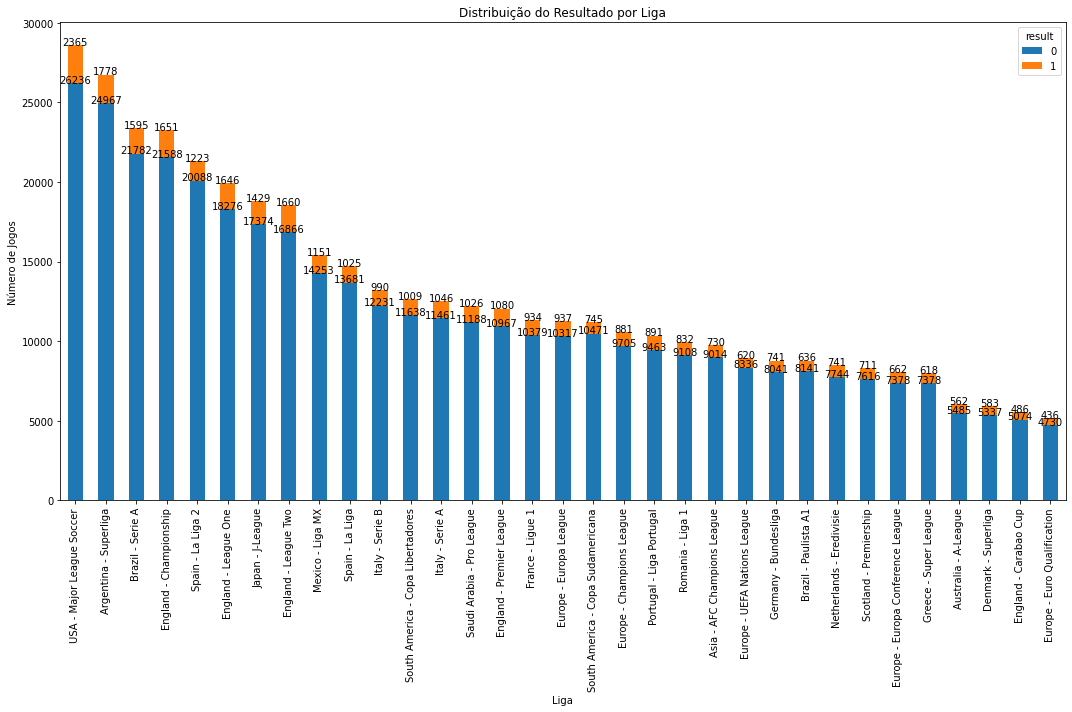

<Figure size 432x288 with 0 Axes>

In [45]:
# Função para filtrar ligas com base no número mínimo de partidas
def filter_leagues(df, league_col, matches, min_matches=100):
    # Agrupa o DataFrame por liga e conta o número único de partidas para cada liga
    league_game_counts = df.groupby(league_col)[matches].nunique()
    # Filtra para manter apenas as ligas com um número de partidas igual ou maior que min_matches
    leagues_filtered = league_game_counts[league_game_counts >= min_matches].index
    # Filtra o DataFrame original para incluir apenas linhas das ligas selecionadas
    filtered_data = df[df[league_col].isin(leagues_filtered)]
    return filtered_data

#     return balanced_data

def balance_data(df, league_col='league', result_col='result'):
    leagues = df[league_col].unique()
    # Lista para armazenar os DataFrames balanceados para cada liga
    balanced_dfs = []

    # Cria uma cópia do DataFrame para não alterar a coluna 'minute' original
    df_copy = df.copy()

    # Itera sobre cada liga para balancear os dados
    for league in leagues:
        # Filtra o DataFrame para incluir apenas dados da liga atual
        league_df = df_copy[df_copy[league_col] == league]
        
        # Arredondando os minutos para o inteiro mais próximo para fins de balanceamento
        league_df['minute_rounded'] = league_df['minute'].round()

        # Selecionando os registros onde 'result' é 1
        result_1 = league_df[league_df[result_col] == 1]

        # Contando os minutos únicos arredondados e suas ocorrências em 'result' 1
        minutes_counts = result_1['minute_rounded'].value_counts()

        # Selecionando registros onde 'result' é 0 e amostrando aleatoriamente com base no número de ocorrências do mesmo minuto arredondado
        result_0_sample = pd.DataFrame()
        for minute, count in minutes_counts.items():
            # Filtra registros com 'result' 0 e o minuto arredondado correspondente
            potential_samples = league_df[(league_df['result'] == 0) & (league_df['minute_rounded'] == minute)]
            
            # Verifica se há registros suficientes para amostrar
            if potential_samples.shape[0] >= count:
                sample = potential_samples.sample(n=count, replace=True, random_state=42)
            else:
                # Se não houver registros suficientes, considera todos os registros disponíveis
                sample = potential_samples

            # Removendo a coluna 'minute_rounded' para manter o formato original de 'minute'
            sample = sample.drop(columns=['minute_rounded'])

            result_0_sample = pd.concat([result_0_sample, sample])

        # Combinando os dois conjuntos de dados para formar um novo dataframe balanceado
        balanced_dfs.append(pd.concat([result_1.drop(columns=['minute_rounded']), result_0_sample]))
    
    # Combina todos os DataFrames balanceados em um único DataFrame
    balanced_data = pd.concat(balanced_dfs).reset_index(drop=True)
    return balanced_data


print("Contando partidas por time...")
total_matches_per_team = len(df['match_id'].unique())
print("Total de partidas:", total_matches_per_team)

print("\nFiltrando dados de ligas...")
filtered_data = filter_leagues(df, 'league', 'match_id')
print("Dados filtrados:\n")
print(filtered_data['league'].value_counts())

print("\nBalanceando dados...")

# balanced_data = balance_data(filtered_data)
balanced_data = filtered_data.copy()

print("Dados balanceados:\n")
print(balanced_data['result'].value_counts())

league_distribution = balanced_data.groupby(['league', 'result']).size().unstack()
sorted_leagues = league_distribution.sum(axis=1).sort_values(ascending=False).head(100).index

print("Contando partidas depois dos filtros...")
total_matches_per_team = len(balanced_data['match_id'].unique())
print("Total de partidas:", total_matches_per_team)

plt.figure(figsize=(15, 10))
ax = league_distribution.loc[sorted_leagues].plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Distribuição do Resultado por Liga')
plt.ylabel('Número de Jogos')
plt.xlabel('Liga')
plt.tight_layout()
plt.xticks(rotation=90)

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.0f}', (x + width/2, y + height), ha='center')

plt.show()
plt.clf()  

In [46]:
# Ordenando o DataFrame
df.sort_values(by=['match_id', 'minute'], inplace=True)

In [47]:
balanced_data.reset_index(drop=True, inplace=True)

In [48]:
balanced_data.value_counts('result')

result
0    396313
1     33420
Name: count, dtype: int64

In [49]:
balanced_data.to_csv("data_live_engineer.csv", index=False, encoding="utf-8")
# df.to_csv("data_live_engineer.csv", index=False, encoding="utf-8")

In [50]:
balanced_data

,minute,homeTeam,awayTeam,goal_home,goal_away,shots_home,shots_away,blockedShots_home,blockedShots_away,league,...,aggresssionOverTime_away,defensiveEfficacy_home,defensiveEfficacy_away,taklesOverTime_home,taklesOverTime_away,possessionControl,passRisk_home,passRisk_away,TotalCards_home,TotalCards_away
0,1.49,Carabobo FC,Club Universitario de Deportes,0.0,0.0,0.0,0.0,0.0,0.0,South America - Copa Libertadores,...,0.000000,0.0,0.000000,0.000000,0.000000,6.0,0.000000,0.0,0.0,0.0
1,1.90,Carabobo FC,Club Universitario de Deportes,0.0,0.0,0.0,0.0,0.0,0.0,South America - Copa Libertadores,...,0.000000,0.0,0.000000,0.000000,0.000000,20.0,0.000000,0.0,0.0,0.0
2,2.28,Carabobo FC,Club Universitario de Deportes,0.0,0.0,0.0,1.0,0.0,1.0,South America - Copa Libertadores,...,0.000000,0.0,100.000000,0.000000,0.438596,16.0,0.000000,0.0,0.0,0.0
3,3.48,Carabobo FC,Club Universitario de Deportes,0.0,0.0,0.0,1.0,0.0,1.0,South America - Copa Libertadores,...,0.000000,0.0,100.000000,0.000000,0.287356,18.0,0.000000,0.0,0.0,0.0
4,3.80,Carabobo FC,Club Universitario de Deportes,0.0,0.0,0.0,1.0,0.0,1.0,South America - Copa Libertadores,...,0.000000,0.0,100.000000,0.000000,0.263158,18.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429728,27.27,Wycombe Wanderers FC,Birmingham City FC,0.0,0.0,0.0,3.0,0.0,2.0,England - League One,...,0.220022,0.0,1.980198,0.256692,0.036670,72.0,0.000000,0.0,1.0,1.0
429729,28.10,Wycombe Wanderers FC,Birmingham City FC,0.0,0.0,0.0,3.0,0.0,2.0,England - League One,...,0.213523,0.0,1.980198,0.249110,0.035587,70.0,0.000000,0.0,1.0,1.0
429730,28.52,Wycombe Wanderers FC,Birmingham City FC,0.0,0.0,0.0,3.0,0.0,2.0,England - League One,...,0.210379,0.0,1.980198,0.245442,0.035063,70.0,0.066622,0.0,1.0,1.0
429731,29.34,Wycombe Wanderers FC,Birmingham City FC,0.0,0.0,0.0,3.0,0.0,2.0,England - League One,...,0.272665,0.0,1.980198,0.238582,0.034083,72.0,0.071378,0.0,2.0,1.0
